#AlphaFold2_advanced_v2_ensembles

WARNING: this is a very very experimental notebook. For anything serious please use our [colabfold](https://github.com/sokrypton/ColabFold) notebooks.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pb3lab/AI4PD_2023/blob/main/colab_notebooks/predict_ensembles_AI4PD.ipynb)

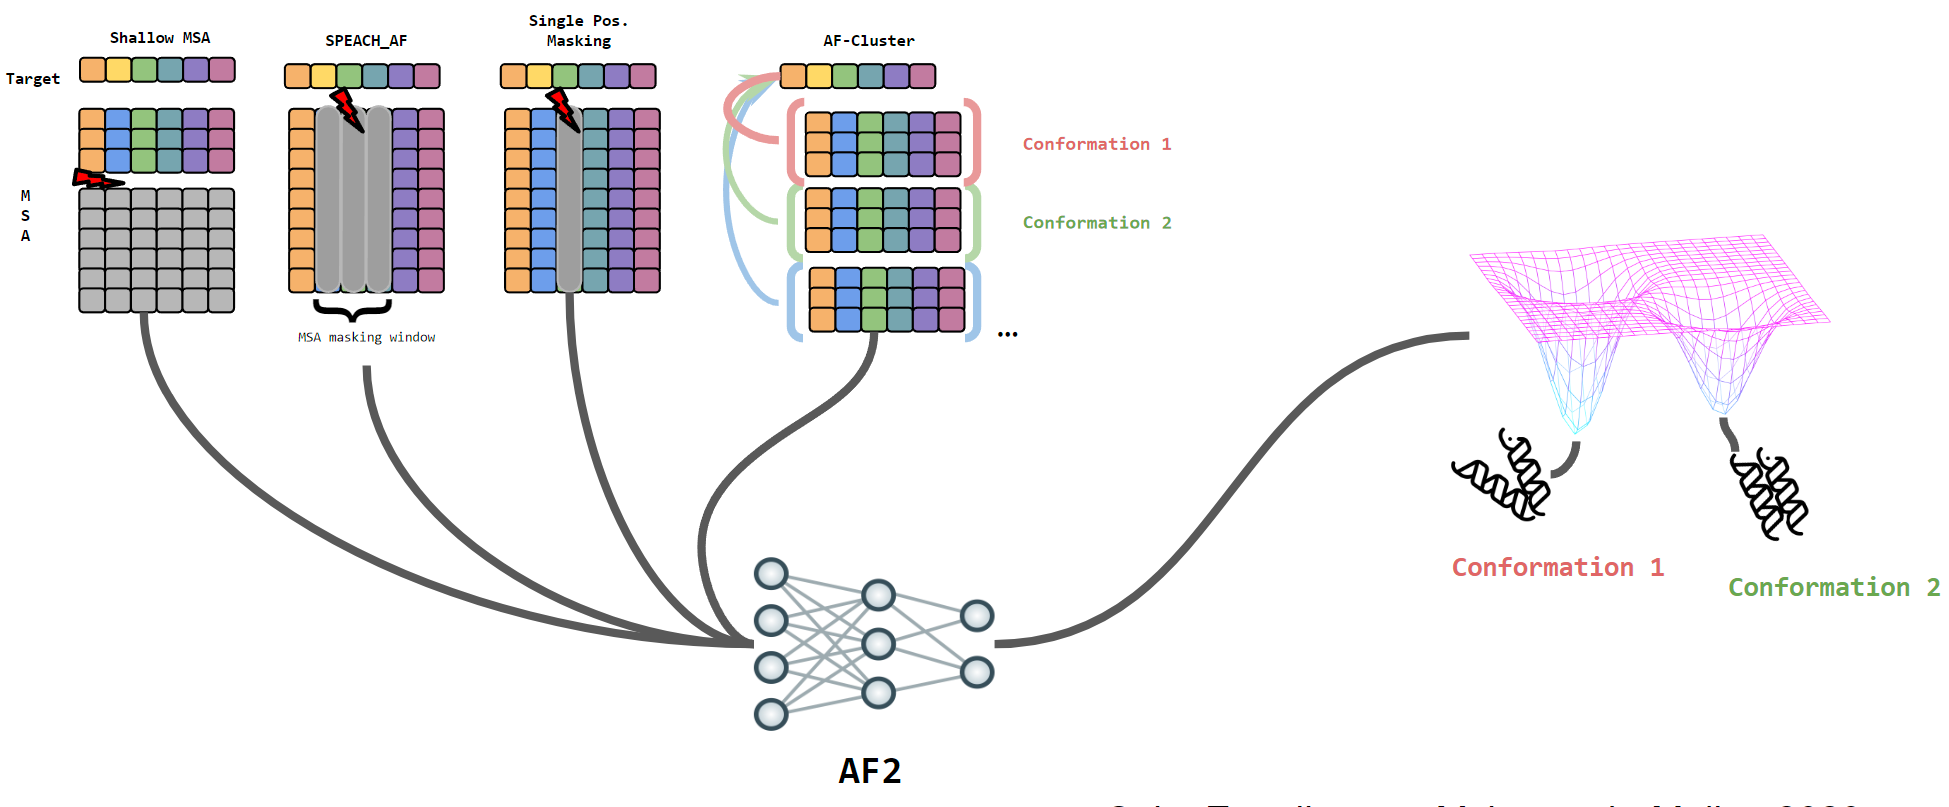

In [ ]:
%%time
#@title setup
unified_memory = True #@param {type:"boolean"}
import os, time, gc
if unified_memory:
  ENV = {"TF_FORCE_UNIFIED_MEMORY":"1", "XLA_PYTHON_CLIENT_MEM_FRACTION":"4.0"}
  for k,v in ENV.items(): os.environ[k] = v
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)

  os.system("wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp")
  os.system("g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp")
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.protein import _np_rmsd, _np_kabsch
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap


import jax
import jax.numpy as jnp
from colabfold_utils import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
    return f"tmp/{pdb_code}.cif"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_do_not_align(query_sequence, target_sequence, **arg):
  return [query_sequence,target_sequence],[0,0]

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

@jax.jit
def get_coevolution(X):
  '''given one-hot encoded MSA, return contacts'''
  Y = jax.nn.one_hot(X,22)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  # covariance
  c = jnp.cov(Y_flat.T)

  # inverse covariance
  shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)

  # partial correlation coefficient
  ic_diag = jnp.diag(ic)
  pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

  raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
  i = jnp.arange(L)
  raw = raw.at[i,i].set(0)
  # do apc
  ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  return (raw - ap).at[i,i].set(0)

def plot_3D(aux, Ls, file_name, show=False):
  plt.figure(figsize=(10,5))
  xyz = aux["atom_positions"][:,1]
  xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
  ax = plt.subplot(1,2,1)
  if len(Ls) > 1:
    plt.title("chain")
    c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
    plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
  else:
    plt.title("length")
    plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
  plt.axis(False)
  ax = plt.subplot(1,2,2)
  plt.title("plddt")
  plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
  plt.axis(False)
  plt.savefig(file_name, dpi=200, bbox_inches='tight')
  plt.show() if show else plt.close()

  !!pip install -U kaleido

In [ ]:
#@title prep_inputs
sequence = "MQSWYLLYCKRGQLQRAQEHLERQAVSCLTPMITLEKMVRGKRTSVSEPLFPNYLFVEFDPEVIHTTTINATRGVSHFVRFGAHPAIVPSSVIHQLSIYKPEGVVDPETPYPGDSVIITEGAFEGLKAIFTEPDGETRSMLLLNLLNKEVKQSVKNTGFRKI" #@param {type:"string"}
jobname = "rfah" #@param {type:"string"}

copies = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 75 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90 #@param ["90", "100"] {type:"raw"}
qid = 0 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}

#@markdown ----
#@markdown **Templates options**
template_mode = "none" #@param ["none", "mmseqs2", "custom"] {type:"string"}
use_templates = template_mode in ["mmseqs2","custom"]
pdb = "" #@param {type:"string"}
chain = "A" #@param {type:"string"}
rm_template_seq = False #@param {type:"boolean"}
propagate_to_copies = True #@param {type:"boolean"}
rm_interchain = False
do_not_align = False #@param {type:"boolean"}
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

print("jobname",jobname)
print(f"length={u_lengths} copies={copies}")

input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":propagate_to_copies}

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=lambda *x: run_mmseqs2(*x, user_agent="colabdesign/gamma"),
    hhfilter_fn=run_hhfilter)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sub_seq}\n")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")

else:
  msa_format = msa_method.split("_")[1]
  print(f"upload {msa_method}")
  msa_dict = files.upload()
  lines = []
  for k,v in msa_dict.items():
    lines += v.decode().splitlines()
  input_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      input_lines.append(line)
  with open(f"{jobname}/msa.{msa_format}","w") as msa:
    msa.write("\n".join(input_lines))
  if msa_format != "a3m":
    os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
  if do_not_filter:
    os.system(f"hhfilter -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  else:
    os.system(f"hhfilter -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()

##################
if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(u_sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=lambda *x: run_mmseqs2(*x, user_agent="colabdesign/gamma"),
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m")
    template_msa = f"{jobname}/msa_tmp.a3m"
    if not propagate_to_copies and copies > 1:
      new_msa = []
      with open(template_msa, "r") as handle:
        for line in handle:
          if not line.startswith(">"):
            new_msa.append(line.rstrip())
      with open(template_msa, "w") as handle:
        for n,seq in enumerate(new_msa):
          handle.write(f">{n}\n{seq*copies}\n")

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
      p = line.rstrip().split()
      M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
      M = int(M)
      if M not in templates:
        templates[M] = []
      if len(templates[M]) < 4:
        print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
        templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print(pdbs)
  else:
    pdbs,chains = [pdb],[chain]

if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb,chain in zip(pdbs,chains):
    query_seq = "".join(u_sequences)
    batch = predict.get_template_feats(pdb, chain,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=propagate_to_copies,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_do_not_align if do_not_align else run_hhalign)
    batches.append(batch)

  # for display
  plt.figure(figsize=(3*len(batches),3))
  for n,batch in enumerate(batches):
    plt.subplot(1,len(batches),n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls * copies)
  plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
  plt.show()
else:
  batches = [None]

################
print("GC",gc.collect())

In [ ]:
#@title pre_analysis (optional)
analysis = "none" # @param ["none", "coevolution"]
dpi = 100 # @param ["100", "200", "300"] {type:"raw"}
if analysis == "coevolution":
  coevol = get_coevolution(msa)
  plt.figure(figsize=(5,5), dpi=dpi)
  plt.title("coevolution")
  plt.imshow(coevol)
  plt.axis(False)
  plt.show()

In [ ]:
#@title prep_model
#@markdown Model options
model_type = "monomer (ptm)" #@param ["monomer (ptm)", "pseudo_multimer (v3)", "multimer (v3)", "auto"]
rank_by = "plddt" #@param ["auto", "plddt", "ptm"]
debug = False #@param {type:"boolean"}
use_initial_guess = False

#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1024 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
use_cluster_profile = True #@param {type:"boolean"}
if model_type == "monomer (ptm)":
  use_multimer = False
  pseudo_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
  pseudo_multimer = False
elif model_type == "pseudo_multimer (v3)":
  use_multimer = True
  pseudo_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
  pseudo_multimer = False
else:
  use_multimer = False
  pseudo_multimer = False

if rank_by == "auto":
  rank_by = "multi" if (len(u_lengths) > 1 or copies > 1) else "plddt"

model_opts = {"num_msa":num_msa,
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_cluster_profile":use_cluster_profile,
              "use_multimer":use_multimer,
              "pseudo_multimer":pseudo_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":rank_by,
              "optimize_seq":False,
              "debug":debug,
              "clear_prev":False}

# initialize the model
if "af" in dir():
  # reuse the model and/or params if already initialized
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    and model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
      clear_mem()
    af = mk_af_model(old_params=old_params,
                     use_mlm=True, # can be disabled later with 0% masking
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(use_mlm=True,
                   **model_opts)
  model_opts_ = predict.copy_dict(model_opts)

# prep inputs
af.prep_inputs(u_lengths, copies=copies, seed=0)
print_key = ["plddt","ptm"]
if len(af._lengths) > 1: print_key += ["i_ptm", "multi"]

# for contact map
af.set_opt("con",cutoff=8.0)

# set templates
if use_templates:
  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence,
             rm_ic=rm_interchain)
# set msa
af.set_msa(msa, deletion_matrix)

# set chainbreaks
L_prev = 0
for n,l in enumerate(u_sub_lengths * copies):
  for L_i in l[:-1]:
    af._inputs["residue_index"][L_prev+L_i:] += 32
    L_prev += L_i
  L_prev += l[-1]

# set cyclic constraints
i_cyclic = [n for n, c in enumerate(u_cyclic * copies) if c]
if len(i_cyclic) > 0:
  add_cyclic_offset(af,i_cyclic)

In [ ]:
%%time
#@title run_alphafold
#@markdown Model options
model = "all" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 6 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.5 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
select_best_across_recycles = True #@param {type:"boolean"}
#@markdown Stochastic options
use_mlm = True #@param {type:"boolean"}
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
#@markdown extras
show_images = True #@param {type:"boolean"}

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess,
            "select_best_across_recycles":select_best_across_recycles,
            "recycle_early_stop_tolerance":recycle_early_stop_tolerance}

# decide which models to use
if model == "all": models = af._model_names
else: models = [af._model_names[int(model) - 1]]

# set options
af.set_opt("mlm", replace_fraction=0.15 if use_mlm else 0.0)

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

# keep track of results
info = []
af._tmp = {"traj":{"seq":[],"xyz":[],"plddt":[],"pae":[]},
           "log":[],"best":{}}

# run
print("running prediction")
with open(f"{jobname}/log.txt","w") as handle:
  # go through all seeds
  seeds = list(range(seed,seed+num_seeds))
  for seed in seeds:
    af.set_seed(seed)
    # go through all models
    for model in models:
      recycle = 0
      af._inputs.pop("prev",None)
      stop_recycle = False
      prev_pos = None
      # go through all recycles
      while recycle < num_recycles + 1:
        print_str = f"seed={seed} model={model} recycle={recycle}"
        af.predict(dropout=use_dropout, models=[model], verbose=False)

        # set previous inputs
        af._inputs["prev"] = af.aux["prev"]

        # save results
        if len(af._lengths) > 1:
          af.aux["log"]["multi"] = 0.8 * af.aux["log"]["i_ptm"] + 0.2 * af.aux["log"]["ptm"]
        af.save_current_pdb(f"{pdb_path}/{model}_r{recycle}_seed{seed}.pdb")

        # print metrics
        for k in print_key: print_str += f" {k}={af.aux['log'][k]:.3f}"

        # early stop check
        current_pos = af.aux["atom_positions"][:,1]
        if recycle > 0:
          rmsd_tol = _np_rmsd(prev_pos, current_pos, use_jax=False)
          if rmsd_tol < recycle_early_stop_tolerance:
            stop_recycle = True
          print_str += f" rmsd_tol={rmsd_tol:.3f}"
        prev_pos = current_pos
        # print metrics
        print(print_str); handle.write(f"{print_str}\n")

        tag = f"{model}_r{recycle}_seed{seed}"
        if select_best_across_recycles:
          info.append([tag,print_str,af.aux["log"][rank_by]])
          af._save_results(save_best=True,
                           best_metric=rank_by, metric_higher_better=True,
                           verbose=False)
          af._k += 1

        recycle += 1
        if stop_recycle: break

      if not select_best_across_recycles:
        info.append([tag,print_str,af.aux["log"][rank_by]])
        af._save_results(save_best=True,
                         best_metric=rank_by, metric_higher_better=True,
                         verbose=False)
        af._k += 1

      # save current results
      plot_3D(af.aux, Ls * copies, f"{pdb_path}/{model}_seed{seed}.pdf", show=show_images)
      predict.plot_confidence(af.aux["plddt"]*100, af.aux["pae"], Ls * copies)
      plt.savefig(f"{pdb_path}/{model}_seed{seed}.png", dpi=200, bbox_inches='tight')
      plt.close()

# save best results
rank = np.argsort([x[2] for x in info])[::-1][:5]
print(f"best_tag={info[rank[0]][0]} {info[rank[0]][1]}")

aux_best = af._tmp["best"]["aux"]
af.save_pdb(f"{pdb_path}/best.pdb")
np.savez_compressed(f"{pdb_path}/best.npz",
                    plddt=aux_best["plddt"].astype(np.float16),
                    pae=aux_best["pae"].astype(np.float16),
                    tag=np.array(info[rank[0]][0]),
                    metrics=np.array(info[rank[0]][1]))
np.savez_compressed(f"{pdb_path}/all.npz",
                    plddt=np.array(af._tmp["traj"]["plddt"], dtype=np.float16),
                    pae=np.array(af._tmp["traj"]["pae"], dtype=np.float16),
                    tag=np.array([x[0] for x in info]),
                    metrics=np.array([x[1] for x in info]))
plot_3D(aux_best, Ls * copies, f"{pdb_path}/best.pdf", show=False)
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], Ls * copies)
plt.savefig(f"{pdb_path}/best.png", dpi=200, bbox_inches='tight')
plt.close()

# garbage collection
print("GC",gc.collect())

In [ ]:
#@title display_best_result (optional) {run: "auto"}
color = "pLDDT" #@param ["pLDDT","chain","rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
color_HP = True

af.plot_pdb(color=color, show_sidechains=show_sidechains, show_mainchains=show_mainchains, color_HP=color_HP)
predict.plot_plddt_legend().show()
aux_best = af._tmp["best"]["aux"]
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], u_lengths * copies).show()

In [ ]:
#@title post_analysis (optional)

analysis = "display_top5_results" # @param ["none", "display_top5_results", "animate_all_results", "coevolution"]
dpi = 100 # @param ["100", "200"] {type:"raw"}

if analysis == "display_top5_results":
  rank = np.argsort([x[2] for x in info])[::-1][:5]
  Ln = sum(Ls)
  plt.figure(figsize=(8,5), dpi=dpi)
  for n in rank:
    plddt = af._tmp["traj"]["plddt"][n] * 100
    plt.plot(plddt, label=info[n][0])
  L_prev = 0
  for L in Ls[:-1]:
    plt.plot([L_prev+L,L_prev+L],[0,100],color="black")
    L_prev += L
  plt.ylim(0,100); plt.ylabel("plddt")
  plt.xlabel('position')
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.savefig(f"{jobname}/top5_plddt.png", dpi=200, bbox_inches='tight')
  plt.show()

  plt.figure(figsize=(25,5), dpi=dpi)
  for i,n in enumerate(rank):
    pae = af._tmp["traj"]["pae"][n]
    plt.subplot(1,5,i+1)
    plt.title(info[n][0])
    plt.imshow(pae,cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls)
  plt.savefig(f"{jobname}/top5_pae.png", dpi=200, bbox_inches='tight')
  plt.show()

if analysis == "animate_all_results":
  af.animate(dpi=dpi)

if analysis == "coevolution":
  def plot_overlay(true, pred, copies=1):
    if copies > 1:
      L = true.shape[0] // copies
      cmap = true.reshape(copies,L,copies,L)

      # inter
      i,j = np.triu_indices(copies, 1)
      cmap_ = np.maximum(cmap[i,:,j,:].max(0),cmap[j,:,i,:].max(0))

      # intra
      i,j = np.diag_indices(copies)
      cmap = cmap[i,:,j,:].max(0)

      i,j = np.triu_indices(L,1)
      plt.scatter(i,j, c="lightpink", s=20, alpha=np.clip(cmap_[i,j],0,1))
      plt.scatter(j,i, c="lightpink", s=20, alpha=np.clip(cmap_[j,i],0,1))
      true = np.maximum(cmap, cmap_)
    else:
      cmap = true
      L = cmap.shape[0]
      i,j = np.triu_indices(L,1)
    plt.scatter(i,j, c="lightgrey", s=20, alpha=np.clip(cmap[i,j],0,1))
    plt.scatter(j,i, c="lightgrey", s=20, alpha=np.clip(cmap[j,i],0,1))

    pred_6 = pred[np.triu_indices(L,6)]
    true = true[i,j]
    mask = pred[i,j] > np.sort(pred_6)[::-1][L]
    bad = (true < 0.5) & mask
    good = (true > 0.5) & mask
    plt.scatter(i[good], j[good], c="blue", s=5)
    plt.scatter(j[good], i[good], c="blue", s=5)
    plt.scatter(i[bad], j[bad], c="red", s=5)
    plt.scatter(j[bad], i[bad], c="red", s=5)

    plt.xlim(0, L); plt.ylim(0, L)
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    plt.axis('equal')
    plt.axis(False)

  cmap = aux_best["cmap"].copy()
  coevol = get_coevolution(msa)
  plt.figure(figsize=(10,5), dpi=dpi)
  plt.subplot(1,2,1); plt.title("agreement")
  plot_overlay(cmap, coevol, copies=copies)
  plt.subplot(1,2,2); plt.title("coevolution")
  plt.imshow(coevol); plt.axis(False)
  plt.savefig(f"{jobname}/coevolution.png", dpi=200, bbox_inches='tight')
  plt.show()

In [ ]:
#@title download_prediction

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = f"{jobname}/settings.txt"
with open(settings_path, "w") as text_file:
  if "input_opts" in dir():
    for k,v in input_opts.items():
      text_file.write(f"{k}={v}\n")
  if "model_opts" in dir():
    for k,v in model_opts.items():
      text_file.write(f"{k}={v}\n")
  if "run_opts" in dir():
    for k,v in run_opts.items():
      text_file.write(f"{k}={v}\n")
# --- Download the predictions ---
os.system(f"zip -r {jobname}.zip {jobname}")
files.download(f'{jobname}.zip')

## AF Cluster

**Now** that we have retrieved the MSA we will proceed to cluster it following the method described by Wayment-Steele, Ovchinnikov, Colwell, Kern (2022) "Prediction of multiple conformational states by combining sequence clustering with AlphaFold2". [bioRxiv](https://www.biorxiv.org/content/10.1101/2022.10.17.512570v1)

### Cluster the MSA

In [ ]:
!pip install -q polyleven
#@title
keyword = "EX" #@param {type:"string"}
input_file = f"{jobname}/msa/1.a3m"
output_directory = "subsampled_MSAs" #@param {type:"string"}

n_controls = 10 #@param {type:"integer"}
verbose = False #@param {type:"boolean"}

scan = False #@param {type:"boolean"}
eps_val = None #@param {type:"raw"}
resample = False #@param {type:"boolean"}
gap_cutoff = 0.25 #@param {type:"number"}
min_eps = 3 #@param {type:"number"}
max_eps = 20 #@param {type:"number"}
eps_step = 0.5 #@param {type:"number"}
min_samples = 3 #@param {type:"number"}

run_PCA = False #@param {type:"boolean"}
run_TSNE = False #@param {type:"boolean"}

#This is copied from the python script from the original repo https://github.com/HWaymentSteele/AFcluster.git

from polyleven import levenshtein
from sklearn.cluster import DBSCAN
#from utils import *
import pandas as pd
from Bio import SeqIO
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from Bio import SeqIO

def lprint(string,f):
    print(string)
    f.write(string+'\n')

def load_fasta(fil):
    seqs, IDs =[], []
    with open(fil) as handle:
            for record in SeqIO.parse(handle, "fasta"):
                seq = ''.join([x for x in record.seq])
                IDs.append(record.id)
                seqs.append(seq)
    return IDs, seqs

def write_fasta(names, seqs, outfile='tmp.fasta'):
        with open(outfile,'w') as f:
                for nm, seq in list(zip(names, seqs)):
                        f.write(">%s\n%s\n" % (nm, seq))

def dihedral_wrapper(traj):
    """Featurize an MD trajectory into a vector space via calculation
    of dihedral (torsion) angles of alpha carbon backbone

    Lifted from MSMBuilder, RT McGibbon

    Parameters
    ----------
    traj : mdtraj.Trajectory
        A molecular dynamics trajectory to featurize.

    Returns
    -------
    features : np.ndarray, dtype=float, shape=(n_samples, n_features)
        A featurized trajectory is a 2D array of shape
        `(length_of_trajectory x n_features)` where each `features[i]`
        vector is computed by applying the featurization function
        to the `i`th snapshot of the input trajectory.

    """

    ca = [a.index for a in traj.top.atoms if a.name == 'CA']
    if len(ca) < 4:
        return np.zeros((len(traj), 0), dtype=np.float32)

    alpha_indices = np.array(
        [(ca[i - 1], ca[i], ca[i+1], ca[i + 2]) for i in range(1, len(ca) - 2)])
    result = md.compute_dihedrals(traj, alpha_indices)

    return result[0]

def consensusVoting(seqs):
    ## Find the consensus sequence
    consensus = ""
    residues = "ACDEFGHIKLMNPQRSTVWY-"
    n_chars = len(seqs[0])
    for i in range(n_chars):
        baseArray = [x[i] for x in seqs]
        baseCount = np.array([baseArray.count(a) for a in list(residues)])
        vote = np.argmax(baseCount)
        consensus += residues[vote]

    return consensus

def encode_seqs(seqs, max_len=108, alphabet=None):

    if alphabet is None:
        alphabet = "ACDEFGHIKLMNPQRSTVWY-"

    arr = np.zeros([len(seqs), max_len, len(alphabet)])
    for j, seq in enumerate(seqs):
        for i,char in enumerate(seq):
            for k, res in enumerate(alphabet):
                if char==res:
                    arr[j,i,k]+=1
    return arr.reshape([len(seqs), max_len*len(alphabet)])


if run_PCA:
    from sklearn.decomposition import PCA

if run_TSNE:
    from sklearn.manifold import TSNE

os.makedirs(f"{jobname}/msa/{output_directory}", exist_ok=True)
f = open("%s.log"% keyword, 'w')
IDs, seqs = load_fasta(input_file)
output_directory = f"{jobname}/msa/{output_directory}"
seqs = [''.join([x for x in s if x.isupper() or x=='-']) for s in seqs] # remove lowercase letters in alignment

df = pd.DataFrame({'SequenceName': IDs, 'sequence': seqs})

query_ = df.iloc[:1]
df = df.iloc[1:]

if resample:
    df = df.sample(frac=1)

L = len(df.sequence.iloc[0])
N = len(df)

df['frac_gaps'] = [x.count('-')/L for x in df['sequence']]

former_len=len(df)
df = df.loc[df.frac_gaps<gap_cutoff]

new_len=len(df)
lprint(keyword, f)
lprint("%d seqs removed for containing more than %d%% gaps, %d remaining" % (former_len-new_len, int(gap_cutoff*100), new_len),f)
ohe_seqs = encode_seqs(df.sequence.tolist(), max_len=L)

n_clusters=[]
eps_test_vals=np.arange(min_eps, max_eps+eps_step, eps_step)

if eps_val is None: # performing scan
  lprint('eps\tn_clusters\tn_not_clustered',f)

  for eps in eps_test_vals:

          testset = encode_seqs(df.sample(frac=0.25).sequence.tolist(), max_len=L)
          clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(testset)
          n_clust = len(set(clustering.labels_))
          n_not_clustered = len(clustering.labels_[np.where(clustering.labels_==-1)])
          lprint('%.2f\t%d\t%d' % (eps, n_clust, n_not_clustered),f)
          n_clusters.append(n_clust)
          if eps>10 and n_clust==1:
              break

  eps_to_select = eps_test_vals[np.argmax(n_clusters)]
else:
  eps_to_select = eps_val


# perform actual clustering

clustering = DBSCAN(eps=eps_to_select, min_samples=min_samples).fit(ohe_seqs)

lprint('Selected eps=%.2f' % eps_to_select,f)

lprint("%d total seqs" % len(df),f)

df['dbscan_label'] = clustering.labels_

clusters = [x for x in df.dbscan_label.unique() if x>=0]
unclustered = len(df.loc[df.dbscan_label==-1])

lprint('%d clusters, %d of %d not clustered (%.2f)' % (len(clusters), unclustered, len(df), unclustered/len(df)),f)

avg_dist_to_query = np.mean([1-levenshtein(x, query_['sequence'].iloc[0])/L for x in df.loc[df.dbscan_label==-1]['sequence'].tolist()])
lprint('avg identity to query of unclustered: %.2f' % avg_dist_to_query,f)

avg_dist_to_query = np.mean([1-levenshtein(x, query_['sequence'].iloc[0])/L for x in df.loc[df.dbscan_label!=-1]['sequence'].tolist()])
lprint('avg identity to query of clustered: %.2f' % avg_dist_to_query, f)

cluster_metadata=[]
for clust in clusters:
    tmp = df.loc[df.dbscan_label==clust]

    cs = consensusVoting(tmp.sequence.tolist())

    avg_dist_to_cs = np.mean([1-levenshtein(x,cs)/L for x in tmp.sequence.tolist()])
    avg_dist_to_query = np.mean([1-levenshtein(x,query_['sequence'].iloc[0])/L for x in tmp.sequence.tolist()])

    if verbose:
        print('Cluster %d consensus seq, %d seqs:' % (clust, len(tmp)))
        print(cs)
        print('#########################################')
        for _, row in tmp.iterrows():
            print(row['SequenceName'], row['sequence'])
        print('#########################################')

    tmp = pd.concat([query_, tmp], axis=0)

    cluster_metadata.append({'cluster_ind': clust, 'consensusSeq': cs, 'avg_lev_dist': '%.3f' % avg_dist_to_cs,
        'avg_dist_to_query': '%.3f' % avg_dist_to_query, 'size': len(tmp)})

    write_fasta(tmp.SequenceName.tolist(), tmp.sequence.tolist(), outfile=output_directory+'/'+keyword+'_'+"%03d" % clust+'.a3m')

print('writing 10 size-10 uniformly sampled clusters')
for i in range(n_controls):
   tmp = df.sample(n=10)
   tmp = pd.concat([query_, tmp], axis=0)
   write_fasta(tmp.SequenceName.tolist(), tmp.sequence.tolist(), outfile=output_directory+'/'+keyword+'_U10-'+"%03d" % i +'.a3m')
if len(df)>100:
    print('writing 10 size-100 uniformly sampled clusters')
    for i in range(n_controls):
        tmp = df.sample(n=100)
        tmp = pd.concat([query_, tmp], axis=0)
        write_fasta(tmp.SequenceName.tolist(), tmp.sequence.tolist(), outfile=output_directory+'/'+keyword+'_U100-'+"%03d" % i +'.a3m')

if run_PCA:
    lprint('Running PCA ...',f)
    ohe_vecs = encode_seqs(df.sequence.tolist(), max_len=L)
    mdl = PCA()
    embedding = mdl.fit_transform(ohe_vecs)

    query_embedding = mdl.transform(encode_seqs(query_.sequence.tolist(), max_len=L))

    df['PC 1'] = embedding[:,0]
    df['PC 2'] = embedding[:,1]

    query_['PC 1'] = query_embedding[:,0]
    query_['PC 2'] = query_embedding[:,1]

    plot_landscape('PC 1', 'PC 2', df, query_, 'PCA')

    lprint('Saved PCA plot to '+output_directory+"/"+keyword+'_PCA.pdf', f)

if run_TSNE:
    lprint('Running TSNE ...',f)
    ohe_vecs = encode_seqs(df.sequence.tolist()+[query_.sequence.tolist()], max_len=L)
    # different than PCA because tSNE doesn't have .transform attribute

    mdl = TSNE()
    embedding = mdl.fit_transform(ohe_vecs)

    df['TSNE 1'] = embedding[:-1,0]
    df['TSNE 2'] = embedding[:-1,1]

    query_['TSNE 1'] = embedding[-1:,0]
    query_['TSNE 2'] = embedding[-1:,1]

    plot_landscape('TSNE 1', 'TSNE 2', df, query_, 'TSNE')

    lprint('Saved TSNE plot to '+output_directory+"/"+keyword+'_TSNE.pdf', f)


outfile = output_directory+"/"+keyword+'_clustering_assignments.tsv'
lprint('wrote clustering data to %s' % outfile, f)
df.to_csv(outfile,index=False, sep='\t')

metad_outfile = output_directory+"/"+keyword+'_cluster_metadata.tsv'
lprint('wrote cluster metadata to %s' % metad_outfile, f)
metad_df = pd.DataFrame.from_records(cluster_metadata)
metad_df.to_csv(metad_outfile,index=False, sep='\t')

print('Saved this output to %s.log' % keyword)
f.close()

In [ ]:
import os
import glob
import numpy as np



#@title run_alphafold for the first 20 clusters for demonstration
#@markdown Model options
model = "2" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 6 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.5 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
select_best_across_recycles = False #@param {type:"boolean"}
#@markdown Stochastic options
use_mlm = False #@param {type:"boolean"}
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
#@markdown extras
show_images = False #@param {type:"boolean"}
# Set this to -1 if you want to predict all the clusters
cluster_number = 20 #@param ["-1", "5", "20", "64", "128"] {type:"raw"}
run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess,
            "select_best_across_recycles":select_best_across_recycles,
            "recycle_early_stop_tolerance":recycle_early_stop_tolerance}

# decide which models to use
if model == "all": models = af._model_names
else: models = [af._model_names[int(model) - 1]]

# set options
af.set_opt("mlm", replace_fraction=0.15 if use_mlm else 0.0)


# Get the list of clusters
clusters = glob.glob(f"{jobname}/msa/subsampled_MSAs/*.a3m")[0:cluster_number]

af._tmp = {"traj":{"seq":[],"xyz":[],"plddt":[],"pae":[]},
          "log":[],"best":{}}
# Loop over the clusters
for i, cluster in enumerate(clusters):
  print(f"Running AlphaFold for cluster {i+1} out of {len(clusters)}")

  # Create a directory for the cluster
  cluster_dir = os.path.join(jobname, f"cluster_{i+1}")
  os.makedirs(cluster_dir, exist_ok=True)

  # Run AlphaFold
  msa, deletion_matrix = predict.parse_a3m(cluster)
  af.set_msa(msa, deletion_matrix)
  # keep track of results
  info = []



  # run
  print("running prediction")
  with open(f"{jobname}/log.txt","w") as handle:
    # go through all seeds
    seeds = list(range(seed,seed+num_seeds))
    for seed in seeds:
      af.set_seed(seed)
      # go through all models
      for model in models:
        recycle = 0
        af._inputs.pop("prev",None)
        stop_recycle = False
        prev_pos = None
        # go through all recycles
        while recycle < num_recycles + 1:
          print_str = f"seed={seed} model={model} recycle={recycle}"
          af.predict(dropout=use_dropout, models=[model], verbose=False)

          # set previous inputs
          af._inputs["prev"] = af.aux["prev"]

          # save results
          if len(af._lengths) > 1:
            af.aux["log"]["multi"] = 0.8 * af.aux["log"]["i_ptm"] + 0.2 * af.aux["log"]["ptm"]
          af.save_current_pdb(f"{cluster_dir}/{model}_r{recycle}_seed{seed}.pdb")

          # print metrics
          for k in print_key: print_str += f" {k}={af.aux['log'][k]:.3f}"

          # early stop check
          current_pos = af.aux["atom_positions"][:,1]
          if recycle > 0:
            rmsd_tol = _np_rmsd(prev_pos, current_pos, use_jax=False)
            if rmsd_tol < recycle_early_stop_tolerance:
              stop_recycle = True
            print_str += f" rmsd_tol={rmsd_tol:.3f}"
          prev_pos = current_pos
          # print metrics
          print(print_str); handle.write(f"{print_str}\n")

          tag = f"{model}_r{recycle}_seed{seed}"
          if select_best_across_recycles:
            info.append([tag,print_str,af.aux["log"][rank_by]])
            af._save_results(save_best=True,
                            best_metric=rank_by, metric_higher_better=True,
                            verbose=False)
            af._k += 1

          recycle += 1
          if stop_recycle: break

        if not select_best_across_recycles:
          info.append([tag,print_str,af.aux["log"][rank_by]])
          af._save_results(save_best=True,
                          best_metric=rank_by, metric_higher_better=True,
                          verbose=False)
          af._k += 1

        # save current results
        plot_3D(af.aux, Ls * copies, f"{cluster_dir}/{model}_seed{seed}.pdf", show=show_images)
        predict.plot_confidence(af.aux["plddt"]*100, af.aux["pae"], Ls * copies)
        plt.savefig(f"{cluster_dir}/{model}_seed{seed}.png", dpi=200, bbox_inches='tight')
        plt.close()

  # save best results
  rank = np.argsort([x[2] for x in info])[::-1][:5]
  print(f"best_tag={info[rank[0]][0]} {info[rank[0]][1]}")
  #os.system(f"cp {info[rank[0]][0]}.pdb {cluster_dir}/cluster_{i+1}_best.pdb")
  aux_best = af._tmp["best"]["aux"]
  #af.save_pdb(f"{cluster_dir}/cluster_{i+1}_best.pdb")
  np.savez_compressed(f"{cluster_dir}/best.npz",
                      plddt=aux_best["plddt"].astype(np.float16),
                      pae=aux_best["pae"].astype(np.float16),
                      tag=np.array(info[rank[0]][0]),
                      metrics=np.array(info[rank[0]][1]))
  np.savez_compressed(f"{cluster_dir}/all.npz",
                      plddt=np.array(af._tmp["traj"]["plddt"], dtype=np.float16),
                      pae=np.array(af._tmp["traj"]["pae"], dtype=np.float16),
                      tag=np.array([x[0] for x in info]),
                      metrics=np.array([x[1] for x in info]))
  plot_3D(aux_best, Ls * copies, f"{cluster_dir}/best.pdf", show=False)
  predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], Ls * copies)
  plt.savefig(f"{cluster_dir}/best.png", dpi=200, bbox_inches='tight')
  plt.close()

  # garbage collection
  print("GC",gc.collect())

print("AlphaFold prediction completed for all clusters.")

# Create a directory for the best models
best_dir = os.path.join(jobname, "best_clusters")
os.makedirs(best_dir, exist_ok=True)

# Get the list of clusters
clusters = glob.glob(f"{jobname}/cluster_*")

# Loop over the clusters
for cluster in clusters:
  # Copy the best model to the best_models directory
  best_model = glob.glob(f"{cluster}/model_2_ptm_r*_seed0.pdb")[0]
  os.system(f"cp {best_model} {jobname}/best_clusters/{cluster.split('/')[-1]}_best.pdb")

In [ ]:
#@title post_analysis (optional)

analysis = "animate_all_results" # @param ["none", "display_top5_results", "animate_all_results", "coevolution"]
dpi = 100 # @param ["100", "200"] {type:"raw"}

if analysis == "display_top5_results":
  rank = np.argsort([x[2] for x in info])[::-1][:5]
  Ln = sum(Ls)
  plt.figure(figsize=(8,5), dpi=dpi)
  for n in rank:
    plddt = af._tmp["traj"]["plddt"][n] * 100
    plt.plot(plddt, label=info[n][0])
  L_prev = 0
  for L in Ls[:-1]:
    plt.plot([L_prev+L,L_prev+L],[0,100],color="black")
    L_prev += L
  plt.ylim(0,100); plt.ylabel("plddt")
  plt.xlabel('position')
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.savefig(f"{jobname}/top5_plddt.png", dpi=200, bbox_inches='tight')
  plt.show()

  plt.figure(figsize=(25,5), dpi=dpi)
  for i,n in enumerate(rank):
    pae = af._tmp["traj"]["pae"][n]
    plt.subplot(1,5,i+1)
    plt.title(info[n][0])
    plt.imshow(pae,cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls)
  plt.savefig(f"{jobname}/top5_pae.png", dpi=200, bbox_inches='tight')
  plt.show()

if analysis == "animate_all_results":
  af.animate(dpi=dpi)

if analysis == "coevolution":
  def plot_overlay(true, pred, copies=1):
    if copies > 1:
      L = true.shape[0] // copies
      cmap = true.reshape(copies,L,copies,L)

      # inter
      i,j = np.triu_indices(copies, 1)
      cmap_ = np.maximum(cmap[i,:,j,:].max(0),cmap[j,:,i,:].max(0))

      # intra
      i,j = np.diag_indices(copies)
      cmap = cmap[i,:,j,:].max(0)

      i,j = np.triu_indices(L,1)
      plt.scatter(i,j, c="lightpink", s=20, alpha=np.clip(cmap_[i,j],0,1))
      plt.scatter(j,i, c="lightpink", s=20, alpha=np.clip(cmap_[j,i],0,1))
      true = np.maximum(cmap, cmap_)
    else:
      cmap = true
      L = cmap.shape[0]
      i,j = np.triu_indices(L,1)
    plt.scatter(i,j, c="lightgrey", s=20, alpha=np.clip(cmap[i,j],0,1))
    plt.scatter(j,i, c="lightgrey", s=20, alpha=np.clip(cmap[j,i],0,1))

    pred_6 = pred[np.triu_indices(L,6)]
    true = true[i,j]
    mask = pred[i,j] > np.sort(pred_6)[::-1][L]
    bad = (true < 0.5) & mask
    good = (true > 0.5) & mask
    plt.scatter(i[good], j[good], c="blue", s=5)
    plt.scatter(j[good], i[good], c="blue", s=5)
    plt.scatter(i[bad], j[bad], c="red", s=5)
    plt.scatter(j[bad], i[bad], c="red", s=5)

    plt.xlim(0, L); plt.ylim(0, L)
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    plt.axis('equal')
    plt.axis(False)

  cmap = aux_best["cmap"].copy()
  coevol = get_coevolution(msa)
  plt.figure(figsize=(10,5), dpi=dpi)
  plt.subplot(1,2,1); plt.title("agreement")
  plot_overlay(cmap, coevol, copies=copies)
  plt.subplot(1,2,2); plt.title("coevolution")
  plt.imshow(coevol); plt.axis(False)
  plt.savefig(f"{jobname}/coevolution.png", dpi=200, bbox_inches='tight')
  plt.show()

In [ ]:
len(af._tmp['traj']['xyz'])

Finally we copy the best structure for each cluster into a best_clusters folder


In [ ]:
#@title download_prediction

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = f"{jobname}/settings.txt"
with open(settings_path, "w") as text_file:
  if "input_opts" in dir():
    for k,v in input_opts.items():
      text_file.write(f"{k}={v}\n")
  if "model_opts" in dir():
    for k,v in model_opts.items():
      text_file.write(f"{k}={v}\n")
  if "run_opts" in dir():
    for k,v in run_opts.items():
      text_file.write(f"{k}={v}\n")
# --- Download the predictions ---
os.system(f"zip -r {jobname}_best.zip {jobname}/best_clusters")
files.download(f'{jobname}_best.zip')

## AF2 Rank

In [ ]:
  # AF2 Rank
  import jax
  from scipy.stats import spearmanr
  import matplotlib.pyplot as plt
  import numpy as np
  import os
  from colabdesign.shared.utils import copy_dict
  from colabdesign import clear_mem, mk_af_model
  import warnings
  import argparse
  import glob
  import pickle
  warnings.simplefilter(action="ignore", category=FutureWarning)

  def plot_composite_vs_tm_i(
      SCORE: dict, dir_save: str, NAME: str, notationsDict: dict = None
  ):
      # Create a dataframe from the SCORE
      df = pd.DataFrame(SCORE)
      # Create a scattter plot of the composite vs tm_i from df columns
      # Use plotly express
      import plotly.express as px

      # color the dots by the composite score
      fig = px.scatter(
          df,
          x="tm_i",
          y="composite",
          color="composite",
          title=f"{NAME}: ranking INPUT decoys using composite score",
      )
      fig.update_traces(hovertemplate="<b>%{text}</b><extra></extra>", text=df["id"])
      # Use the pastel color scale
      fig.update_layout(coloraxis_colorscale="Portland")
      # Make the figure square
      fig.update_layout(width=750, height=750)
      # If notationsDict is not empty, add the notations to the figure
      if notationsDict:
          # For each key in the notationsDict
          for key in notationsDict:
              # Add an arrow to the structure in notationDict[key]
              fig.add_annotation(
                  x=df["tm_i"][df["id"].str.contains(f"{notationsDict[key]}")].values[0],
                  y=df["composite"][
                      df["id"].str.contains(f"{notationsDict[key]}")
                  ].values[0],
                  text=df[df["id"].str.contains(f"{notationsDict[key]}")]["id"]
                  .values[0]
                  .replace("unrelaxed_rank_1_", "")
                  .replace("_", " ")
                  .replace(".pdb", ""),
                  showarrow=True,
                  arrowhead=1,
                  bgcolor="white",
                  font_color="black",
              )
      # Center the title and bold use br tags
      fig.update_layout(
          title={
              "text": f"{NAME}: ranking INPUT decoys using composite score",
              "y": 0.9,
              "x": 0.5,
              "xanchor": "center",
              "yanchor": "top",
          },
          title_font_size=20,
      )
      labels = {
          "tm_i": "TMscore of Input",
          "tm_o": "TMscore of Output",
          "tm_io": "TMscore between Input and Output",
          "ptm": "Predicted TMscore (pTM)",
          "i_ptm": "Predicted interface TMscore (ipTM)",
          "plddt": "Predicted LDDT (pLDDT)",
          "composite": "Composite",
      }
      fig.update_xaxes(title_text=labels["tm_i"])
      fig.update_yaxes(title_text=labels["composite"])
      # make the dots bigger
      fig.update_traces(marker_size=10)
      fig.show()
      # save the plot to dir_save
      fig.write_image(os.path.join(dir_save, f"{NAME}_composite_vs_tm_i.pdf"))
      fig.write_image(os.path.join(dir_save, f"{NAME}_composite_vs_tm_i.png"))


  class af2rank:
      def __init__(self, pdb, filterTag, chain=None, model_name="model_1_ptm", model_names=None):
          self.filterTag = filterTag
          self.args = {
              "pdb": pdb,
              "chain": chain,
              "use_multimer": ("multimer" in model_name),
              "model_name": model_name,
              "model_names": model_names,
              "filterTag": filterTag,

          }

          self.reset()

      def reset(self):
          self.model = mk_af_model(
              protocol="fixbb",
              use_templates=True,
              use_multimer=self.args["use_multimer"],
              #use_alphafold=True,
              #use_openfold=True,
              debug=False,
              model_names=self.args["model_names"],
          )

          self.model.prep_inputs(self.args["pdb"], chain=self.args["chain"])
          self.model.set_seq(mode="wildtype")
          self.wt_batch = copy_dict(self.model._inputs["batch"])
          self.wt = self.model._wt_aatype




      def set_pdb(self, pdb, chain=None):
          if chain is None:
              chain = self.args["chain"]
          self.model.prep_inputs(pdb, chain=chain)
          self.model.set_seq(mode="wildtype")
          self.wt = self.model._wt_aatype

      def set_seq(self, seq):
          self.model.set_seq(seq=seq)
          self.wt = self.model._params["seq"][0].argmax(-1)

      def _tmscore(self, x, y):
              # save to dumpy pdb files
              for n, z in enumerate([x, y]):
                  out = open(f"{n}_{self.filterTag}.pdb", "w")
                  for k, c in enumerate(z):
                      out.write(
                          "ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                          % (k + 1, "CA", "ALA", "A", k + 1, c[0], c[1], c[2], 1, 0)
                      )
                  out.close()
              # pass to TMscore
              # TMscore path
              tmscore_path = "/content/TMscore"
              # ('./TMscore 0.pdb 1.pdb')
              output = os.popen(f"{tmscore_path} 0_{self.filterTag}.pdb 1_{self.filterTag}.pdb")

              # parse outputs
              def parse_float(x):
                  return float(x.split("=")[1].split()[0])

              o = {}
              for line in output:
                  line = line.rstrip()
                  if line.startswith("RMSD"):
                      o["rms"] = parse_float(line)
                  if line.startswith("TM-score"):
                      o["tms"] = parse_float(line)
                  if line.startswith("GDT-TS-score"):
                      o["gdt"] = parse_float(line)

              return o

      def _get_score(self):

          score = copy_dict(self.model.aux["log"])

          score["plddt"] = score["plddt"]
          score["pae"] = 31.0 * score["pae"]
          score["rmsd_io"] = score.pop("rmsd", None)

          i_xyz = self.model._inputs["batch"]["all_atom_positions"][:, 1]
          o_xyz = np.array(self.model.aux["atom_positions"][:, 1])

          # TMscore to input/output
          if hasattr(self, "wt_batch"):
              n_xyz = self.wt_batch["all_atom_positions"][:, 1]
              score["tm_i"] = self._tmscore(n_xyz, i_xyz)["tms"]
              score["tm_o"] = self._tmscore(n_xyz, o_xyz)["tms"]

          # TMscore between input and output
          score["tm_io"] = self._tmscore(i_xyz, o_xyz)["tms"]

          # composite score
          score["composite"] = score["ptm"] * score["plddt"] * score["tm_io"]
          return score

      def predict(
          self,
          pdb=None,
          seq=None,
          chain=None,
          input_template=True,
          model_name=None,
          rm_seq=True,
          rm_sc=True,
          rm_ic=False,
          recycles=1,
          iterations=1,
          output_pdb=None,
          extras=None,
          verbose=True,
      ):
          if model_name is not None:
              self.args["model_name"] = model_name
              if "multimer" in model_name:
                  if not self.args["use_multimer"]:
                      self.args["use_multimer"] = True
                      self.reset()
              else:
                  if self.args["use_multimer"]:
                      self.args["use_multimer"] = False
                      self.reset()

          if pdb is not None:
              self.set_pdb(pdb, chain)
          if seq is not None:
              self.set_seq(seq)

          # set template sequence
          self.model._inputs["batch"]["aatype"] = self.wt

          # set other options
          self.model.set_opt(
              template=dict( rm_ic=rm_ic),
              num_recycles=recycles,
          )
          #self.model._inputs["rm_template_sc"][:] = rm_sc
          #self.model._inputs["rm_template_seq"][:] = rm_seq

          # "manual" recycles using templates
          ini_atoms = self.model._inputs["batch"]["all_atom_positions"].copy()
          for i in range(iterations):
              self.model.predict(models=self.args["model_name"], verbose=True)
              if i < iterations - 1:
                  self.model._inputs["batch"]["all_atom_positions"] = self.model.aux[
                      "atom_positions"
                  ]
              else:
                  self.model._inputs["batch"]["all_atom_positions"] = ini_atoms

          score = self._get_score()
          if extras is not None:
              score.update(extras)

          if output_pdb is not None:
              self.model.save_pdb(output_pdb)

          if verbose:
              print_list = [
                  "tm_i",
                  "tm_o",
                  "tm_io",
                  "composite",
                  "ptm",
                  "i_ptm",
                  "plddt",
                  "fitness",
                  "id",
              ]

              def print_score(k):
                  return (
                      f"{k} {score[k]:.4f}"
                      if isinstance(score[k], float)
                      else f"{k} {score[k]}"
                  )

              # print(*[print_score(k) for k in print_list if k in score])

          return score


  def run_af2rank(
      parentPath: str,
      systemName: str,
      experimentTag: str,
      save_output_pdbs: bool = False,
      overwrite: bool = False,
      recycles: int = 1,
      iterations: int = 1,
      model_mode: str = "alphafold",
      model_num: int = 1,
      mask_sequence: bool = True,
      mask_sidechains: bool = True,
      mask_interchain: bool = False,
      chain: str = "A",
      filterTag: str = "rank_1",
      paramsPath: str = "/content",
  ):
      """ run_af2rank from sergey's notebook

      Args:
          parentPath (str): [description]
          systemName (str): [description]
          experimentTag (str): [description]
          save_output_pdbs (bool, optional): [description]. Defaults to False.
          overwrite (bool, optional): [description]. Defaults to False.
          recycles (int, optional): ["0", "1", "2", "3", "4"]. Defaults to 1.
          iterations (int, optional): [description]. Defaults to 1.
          model_mode (str, optional): ["alphafold", "alphafold-multimer", "openfold"]. Defaults to "alphafold".
          model_num (int, optional): ["1", "2", "3", "4", "5"]. Defaults to 1.
          mask_sequence (bool, optional): [description]. Defaults to True.
          mask_sidechains (bool, optional): [description]. Defaults to True.
          mask_interchain (bool, optional): [description]. Defaults to False.
          chain (str, optional): [description]. Defaults to 'A'.
          filterTag (str, optional): [description]. Defaults to 'rank_1'.
      """
      # Change to paramsPath
      # os.chdir(paramsPath)
      # @markdown ### **settings**
      recycles = recycles
      iterations = iterations

      # decide what model to use
      model_mode = model_mode
      model_num = model_num

      if model_mode == "alphafold":
          model_name = f"model_{model_num}_ptm"
      if model_mode == "alphafold-multimer":
          model_name = f"model_{model_num}_multimer_v2"
      if model_mode == "openfold":
          model_name = f"openfold_model_ptm_{model_num}"

      save_output_pdbs = save_output_pdbs

      # @markdown ### **advanced**
      mask_sequence = mask_sequence
      mask_sidechains = mask_sidechains
      mask_interchain = mask_interchain

      SETTINGS = {
          "rm_seq": mask_sequence,
          "rm_sc": mask_sidechains,
          "rm_ic": mask_interchain,
          "recycles": int(recycles),
          "iterations": int(iterations),
          "model_name": model_name,
      }
      NAME = systemName
      CHAIN = chain
      # Create a native path for f'{parentPath}/{systemName}/initial_prediction/*rank_1*.pdb' use glob
      NATIVE_PATH = glob.glob(
          f"{parentPath}/{systemName}/pdb/best.pdb"
      )[0]
      DECOY_DIR = f"{parentPath}/{systemName}/best_clusters"
      if save_output_pdbs:
          os.makedirs(
              f"{parentPath}/{systemName}/pdb/af2rank/pdbs",
              exist_ok=True,
          )
      # setup model
      clear_mem()
      af = af2rank(pdb=NATIVE_PATH, chain=CHAIN, model_name=SETTINGS["model_name"], filterTag=filterTag)
      # Create a directory for the best models
      best_dir = os.path.join(jobname, "af2rank")
      os.makedirs(best_dir, exist_ok=True)
      #os.chdir(f"{parentPath}/{systemName}/af2rank")
      # score no structure
      _ = af.predict(pdb=NATIVE_PATH, input_template=False, **SETTINGS)
      SCORES = []
      # score native structure
      SCORES.append(af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id": NATIVE_PATH}))
      import tqdm

      # Loop over the '.pdb' files in the DECOY_DIR
      for decoy_pdb in tqdm.tqdm(glob.glob(f"{DECOY_DIR}/*{filterTag}*.pdb")):
          print(decoy_pdb)
          # If decoy_pdb ends with .pdb, then it is a decoy structure
          if decoy_pdb.endswith(".pdb"):
              # If decoy_pdb contains 'rank_1' in its name, then it is the native structure
              if "_best" in decoy_pdb:
                  input_pdb = os.path.join(DECOY_DIR, decoy_pdb)
                  if save_output_pdbs:
                      output_pdb = os.path.join(
                          f"{parentPath}/{systemName}/af2rank/pdbs",
                          decoy_pdb,
                      )
                  else:
                      output_pdb = None
                  SCORES.append(
                      af.predict(
                          pdb=input_pdb,
                          output_pdb=output_pdb,
                          **SETTINGS,
                          extras={"id": decoy_pdb},
                      )
                  )


      import pandas as pd

      SCORES_df = pd.DataFrame(SCORES)
      SCORES_df.to_csv(f"{parentPath}/{systemName}/af2rank/SCORES.csv")

      plot_composite_vs_tm_i(SCORES,dir_save=f"/content/{jobname}/af2rank",NAME="Test")
      # Skip if the checkpoint file already exists and overwrite is false, save otherwise
      # f'{parentPath}/cryptic-pocket/{uniprotID}/second_prediction_12recycles_6replicas/pickle/{uniprotID}_checkpoint.pkl'
      if not os.path.exists(
          f"{parentPath}/{systemName}/af2rank/{systemName}_{filterTag}_af2rank.pkl"
      ):
          with open(
              f"{parentPath}/{systemName}/af2rank/{systemName}_{filterTag}_af2rank.pkl",
              "wb",
          ) as f:
              pickle.dump(SCORES, f)
      # else if it exists and overwrite is true, then save
      elif (
          os.path.exists(
              f"{parentPath}/{systemName}/af2rank/{systemName}_{filterTag}_af2rank.pkl"
          )
          and overwrite
      ):
          with open(
              f"{parentPath}/{systemName}/af2rank/{systemName}_{filterTag}_af2rank.pkl",
              "wb",
          ) as f:
              pickle.dump(SCORES, f)


  #@title Run af2rank
  parentPath = "/content" #@param {type:"string"}
  systemName = jobname
  experimentTag = "" # param {type:"string"}
  save_output_pdbs = False #@param {type:"boolean"}
  overwrite = False #@param {type:"boolean"}
  recycles = 1 #@param {type:"integer"}
  iterations = 1 #@param {type:"integer"}
  model_mode = "alphafold" #@param {type:"string"}
  model_num = 1 #@param {type:"integer"}
  mask_sequence = True #@param {type:"boolean"}
  mask_sidechains = True #@param {type:"boolean"}
  mask_interchain = False #@param {type:"boolean"}
  chain = "A" #@param {type:"string"}
  filterTag = "cluster_" #@param {type:"string"}

  run_af2rank(
          parentPath,
          systemName,
          experimentTag,
          save_output_pdbs,
          overwrite,
          recycles,
          iterations,
          model_mode,
          model_num,
          mask_sequence,
          mask_sidechains,
          mask_interchain,
          chain,
          filterTag,
      )


## Dropout

Another method to sample conformations is to activate dropout as first introduced by AFsample: improving multimer prediction with AlphaFold using massive sampling. Björn Wallner. [Paper](https://academic.oup.com/bioinformatics/article/39/9/btad573/7274860?login=false)

In [ ]:
#@title prep_inputs
sequence = "MQSWYLLYCKRGQLQRAQEHLERQAVSCLTPMITLEKMVRGKRTSVSEPLFPNYLFVEFDPEVIHTTTINATRGVSHFVRFGAHPAIVPSSVIHQLSIYKPEGVVDPETPYPGDSVIITEGAFEGLKAIFTEPDGETRSMLLLNLLNKEVKQSVKNTGFRKI" #@param {type:"string"}
jobname = "rfah-dropout" #@param {type:"string"}

copies = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 75 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90 #@param ["90", "100"] {type:"raw"}
qid = 0 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}

#@markdown ----
#@markdown **Templates options**
template_mode = "none" #@param ["none", "mmseqs2", "custom"] {type:"string"}
use_templates = template_mode in ["mmseqs2","custom"]
pdb = "" #@param {type:"string"}
chain = "A" #@param {type:"string"}
rm_template_seq = False #@param {type:"boolean"}
propagate_to_copies = True #@param {type:"boolean"}
rm_interchain = False
do_not_align = False #@param {type:"boolean"}
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

print("jobname",jobname)
print(f"length={u_lengths} copies={copies}")

input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":propagate_to_copies}

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=lambda *x: run_mmseqs2(*x, user_agent="colabdesign/gamma"),
    hhfilter_fn=run_hhfilter)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sub_seq}\n")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")

else:
  msa_format = msa_method.split("_")[1]
  print(f"upload {msa_method}")
  msa_dict = files.upload()
  lines = []
  for k,v in msa_dict.items():
    lines += v.decode().splitlines()
  input_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      input_lines.append(line)
  with open(f"{jobname}/msa.{msa_format}","w") as msa:
    msa.write("\n".join(input_lines))
  if msa_format != "a3m":
    os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
  if do_not_filter:
    os.system(f"hhfilter -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  else:
    os.system(f"hhfilter -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()

##################
if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(u_sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=lambda *x: run_mmseqs2(*x, user_agent="colabdesign/gamma"),
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m")
    template_msa = f"{jobname}/msa_tmp.a3m"
    if not propagate_to_copies and copies > 1:
      new_msa = []
      with open(template_msa, "r") as handle:
        for line in handle:
          if not line.startswith(">"):
            new_msa.append(line.rstrip())
      with open(template_msa, "w") as handle:
        for n,seq in enumerate(new_msa):
          handle.write(f">{n}\n{seq*copies}\n")

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
      p = line.rstrip().split()
      M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
      M = int(M)
      if M not in templates:
        templates[M] = []
      if len(templates[M]) < 4:
        print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
        templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print(pdbs)
  else:
    pdbs,chains = [pdb],[chain]

if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb,chain in zip(pdbs,chains):
    query_seq = "".join(u_sequences)
    batch = predict.get_template_feats(pdb, chain,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=propagate_to_copies,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_do_not_align if do_not_align else run_hhalign)
    batches.append(batch)

  # for display
  plt.figure(figsize=(3*len(batches),3))
  for n,batch in enumerate(batches):
    plt.subplot(1,len(batches),n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls * copies)
  plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
  plt.show()
else:
  batches = [None]

################
print("GC",gc.collect())

In [ ]:
#@title pre_analysis (optional)
analysis = "none" # @param ["none", "coevolution"]
dpi = 100 # @param ["100", "200", "300"] {type:"raw"}
if analysis == "coevolution":
  coevol = get_coevolution(msa)
  plt.figure(figsize=(5,5), dpi=dpi)
  plt.title("coevolution")
  plt.imshow(coevol)
  plt.axis(False)
  plt.show()

In [ ]:
#@title prep_model
#@markdown Model options
model_type = "monomer (ptm)" #@param ["monomer (ptm)", "pseudo_multimer (v3)", "multimer (v3)", "auto"]
rank_by = "plddt" #@param ["auto", "plddt", "ptm"]
debug = False #@param {type:"boolean"}
use_initial_guess = False

#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1024 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
use_cluster_profile = True #@param {type:"boolean"}
if model_type == "monomer (ptm)":
  use_multimer = False
  pseudo_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
  pseudo_multimer = False
elif model_type == "pseudo_multimer (v3)":
  use_multimer = True
  pseudo_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
  pseudo_multimer = False
else:
  use_multimer = False
  pseudo_multimer = False

if rank_by == "auto":
  rank_by = "multi" if (len(u_lengths) > 1 or copies > 1) else "plddt"

model_opts = {"num_msa":num_msa,
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_cluster_profile":use_cluster_profile,
              "use_multimer":use_multimer,
              "pseudo_multimer":pseudo_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":rank_by,
              "optimize_seq":False,
              "debug":debug,
              "clear_prev":False}

# initialize the model
if "af" in dir():
  # reuse the model and/or params if already initialized
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    and model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
      clear_mem()
    af = mk_af_model(old_params=old_params,
                     use_mlm=True, # can be disabled later with 0% masking
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(use_mlm=True,
                   **model_opts)
  model_opts_ = predict.copy_dict(model_opts)

# prep inputs
af.prep_inputs(u_lengths, copies=copies, seed=0)
print_key = ["plddt","ptm"]
if len(af._lengths) > 1: print_key += ["i_ptm", "multi"]

# for contact map
af.set_opt("con",cutoff=8.0)

# set templates
if use_templates:
  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence,
             rm_ic=rm_interchain)
# set msa
af.set_msa(msa, deletion_matrix)

# set chainbreaks
L_prev = 0
for n,l in enumerate(u_sub_lengths * copies):
  for L_i in l[:-1]:
    af._inputs["residue_index"][L_prev+L_i:] += 32
    L_prev += L_i
  L_prev += l[-1]

# set cyclic constraints
i_cyclic = [n for n, c in enumerate(u_cyclic * copies) if c]
if len(i_cyclic) > 0:
  add_cyclic_offset(af,i_cyclic)

In [ ]:
%%time
#@title run_alphafold (if you get an error restart the runtime)
#@markdown Model options
model = "2" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 2 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.5 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
select_best_across_recycles = True #@param {type:"boolean"}
#@markdown Stochastic options
use_mlm = True #@param {type:"boolean"}
use_dropout = True #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 4 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
#@markdown extras
show_images = False #@param {type:"boolean"}

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess,
            "select_best_across_recycles":select_best_across_recycles,
            "recycle_early_stop_tolerance":recycle_early_stop_tolerance}

# decide which models to use
if model == "all": models = af._model_names
else: models = [af._model_names[int(model) - 1]]

# set options
af.set_opt("mlm", replace_fraction=0.15 if use_mlm else 0.0)

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

# keep track of results
info = []
af._tmp = {"traj":{"seq":[],"xyz":[],"plddt":[],"pae":[]},
           "log":[],"best":{}}

# run
print("running prediction")
with open(f"{jobname}/log.txt","w") as handle:
  # go through all seeds
  seeds = list(range(seed,seed+num_seeds))
  for seed in seeds:
    af.set_seed(seed)
    # go through all models
    for model in models:
      recycle = 0
      af._inputs.pop("prev",None)
      stop_recycle = False
      prev_pos = None
      # go through all recycles
      while recycle < num_recycles + 1:
        print_str = f"seed={seed} model={model} recycle={recycle}"
        af.predict(dropout=use_dropout, models=[model], verbose=False)

        # set previous inputs
        af._inputs["prev"] = af.aux["prev"]

        # save results
        if len(af._lengths) > 1:
          af.aux["log"]["multi"] = 0.8 * af.aux["log"]["i_ptm"] + 0.2 * af.aux["log"]["ptm"]
        af.save_current_pdb(f"{pdb_path}/{model}_r{recycle}_seed{seed}.pdb")

        # print metrics
        for k in print_key: print_str += f" {k}={af.aux['log'][k]:.3f}"

        # early stop check
        current_pos = af.aux["atom_positions"][:,1]
        if recycle > 0:
          rmsd_tol = _np_rmsd(prev_pos, current_pos, use_jax=False)
          if rmsd_tol < recycle_early_stop_tolerance:
            stop_recycle = True
          print_str += f" rmsd_tol={rmsd_tol:.3f}"
        prev_pos = current_pos
        # print metrics
        print(print_str); handle.write(f"{print_str}\n")

        tag = f"{model}_r{recycle}_seed{seed}"
        if select_best_across_recycles:
          info.append([tag,print_str,af.aux["log"][rank_by]])
          af._save_results(save_best=True,
                           best_metric=rank_by, metric_higher_better=True,
                           verbose=False)
          af._k += 1

        recycle += 1
        if stop_recycle: break

      if not select_best_across_recycles:
        info.append([tag,print_str,af.aux["log"][rank_by]])
        af._save_results(save_best=True,
                         best_metric=rank_by, metric_higher_better=True,
                         verbose=False)
        af._k += 1

      # save current results
      plot_3D(af.aux, Ls * copies, f"{pdb_path}/{model}_seed{seed}.pdf", show=show_images)
      predict.plot_confidence(af.aux["plddt"]*100, af.aux["pae"], Ls * copies)
      plt.savefig(f"{pdb_path}/{model}_seed{seed}.png", dpi=200, bbox_inches='tight')
      plt.close()

# save best results
rank = np.argsort([x[2] for x in info])[::-1][:5]
print(f"best_tag={info[rank[0]][0]} {info[rank[0]][1]}")

aux_best = af._tmp["best"]["aux"]
af.save_pdb(f"{pdb_path}/best.pdb")
np.savez_compressed(f"{pdb_path}/best.npz",
                    plddt=aux_best["plddt"].astype(np.float16),
                    pae=aux_best["pae"].astype(np.float16),
                    tag=np.array(info[rank[0]][0]),
                    metrics=np.array(info[rank[0]][1]))
np.savez_compressed(f"{pdb_path}/all.npz",
                    plddt=np.array(af._tmp["traj"]["plddt"], dtype=np.float16),
                    pae=np.array(af._tmp["traj"]["pae"], dtype=np.float16),
                    tag=np.array([x[0] for x in info]),
                    metrics=np.array([x[1] for x in info]))
plot_3D(aux_best, Ls * copies, f"{pdb_path}/best.pdf", show=False)
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], Ls * copies)
plt.savefig(f"{pdb_path}/best.png", dpi=200, bbox_inches='tight')
plt.close()

# garbage collection
print("GC",gc.collect())

In [ ]:
#@title display_best_result (optional) {run: "auto"}
color = "pLDDT" #@param ["pLDDT","chain","rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
color_HP = True

af.plot_pdb(color=color, show_sidechains=show_sidechains, show_mainchains=show_mainchains, color_HP=color_HP)
predict.plot_plddt_legend().show()
aux_best = af._tmp["best"]["aux"]
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], u_lengths * copies).show()

In [ ]:
#@title post_analysis (optional)

analysis = "animate_all_results" # @param ["none", "display_top5_results", "animate_all_results", "coevolution"]
dpi = 100 # @param ["100", "200"] {type:"raw"}

if analysis == "display_top5_results":
  rank = np.argsort([x[2] for x in info])[::-1][:5]
  Ln = sum(Ls)
  plt.figure(figsize=(8,5), dpi=dpi)
  for n in rank:
    plddt = af._tmp["traj"]["plddt"][n] * 100
    plt.plot(plddt, label=info[n][0])
  L_prev = 0
  for L in Ls[:-1]:
    plt.plot([L_prev+L,L_prev+L],[0,100],color="black")
    L_prev += L
  plt.ylim(0,100); plt.ylabel("plddt")
  plt.xlabel('position')
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.savefig(f"{jobname}/top5_plddt.png", dpi=200, bbox_inches='tight')
  plt.show()

  plt.figure(figsize=(25,5), dpi=dpi)
  for i,n in enumerate(rank):
    pae = af._tmp["traj"]["pae"][n]
    plt.subplot(1,5,i+1)
    plt.title(info[n][0])
    plt.imshow(pae,cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls)
  plt.savefig(f"{jobname}/top5_pae.png", dpi=200, bbox_inches='tight')
  plt.show()

if analysis == "animate_all_results":
  af.animate(dpi=dpi)

if analysis == "coevolution":
  def plot_overlay(true, pred, copies=1):
    if copies > 1:
      L = true.shape[0] // copies
      cmap = true.reshape(copies,L,copies,L)

      # inter
      i,j = np.triu_indices(copies, 1)
      cmap_ = np.maximum(cmap[i,:,j,:].max(0),cmap[j,:,i,:].max(0))

      # intra
      i,j = np.diag_indices(copies)
      cmap = cmap[i,:,j,:].max(0)

      i,j = np.triu_indices(L,1)
      plt.scatter(i,j, c="lightpink", s=20, alpha=np.clip(cmap_[i,j],0,1))
      plt.scatter(j,i, c="lightpink", s=20, alpha=np.clip(cmap_[j,i],0,1))
      true = np.maximum(cmap, cmap_)
    else:
      cmap = true
      L = cmap.shape[0]
      i,j = np.triu_indices(L,1)
    plt.scatter(i,j, c="lightgrey", s=20, alpha=np.clip(cmap[i,j],0,1))
    plt.scatter(j,i, c="lightgrey", s=20, alpha=np.clip(cmap[j,i],0,1))

    pred_6 = pred[np.triu_indices(L,6)]
    true = true[i,j]
    mask = pred[i,j] > np.sort(pred_6)[::-1][L]
    bad = (true < 0.5) & mask
    good = (true > 0.5) & mask
    plt.scatter(i[good], j[good], c="blue", s=5)
    plt.scatter(j[good], i[good], c="blue", s=5)
    plt.scatter(i[bad], j[bad], c="red", s=5)
    plt.scatter(j[bad], i[bad], c="red", s=5)

    plt.xlim(0, L); plt.ylim(0, L)
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    plt.axis('equal')
    plt.axis(False)

  cmap = aux_best["cmap"].copy()
  coevol = get_coevolution(msa)
  plt.figure(figsize=(10,5), dpi=dpi)
  plt.subplot(1,2,1); plt.title("agreement")
  plot_overlay(cmap, coevol, copies=copies)
  plt.subplot(1,2,2); plt.title("coevolution")
  plt.imshow(coevol); plt.axis(False)
  plt.savefig(f"{jobname}/coevolution.png", dpi=200, bbox_inches='tight')
  plt.show()

## AF2 Rank

In [ ]:
  # AF2 Rank
  import jax
  from scipy.stats import spearmanr
  import matplotlib.pyplot as plt
  import numpy as np
  import os
  from colabdesign.shared.utils import copy_dict
  from colabdesign import clear_mem, mk_af_model
  import warnings
  import argparse
  import glob
  import pickle
  warnings.simplefilter(action="ignore", category=FutureWarning)
  import pandas as pd

  def plot_composite_vs_tm_i(
      SCORE: dict, dir_save: str, NAME: str, notationsDict: dict = None
  ):
      # Create a dataframe from the SCORE
      df = pd.DataFrame(SCORE)
      # Create a scattter plot of the composite vs tm_i from df columns
      # Use plotly express
      import plotly.express as px

      # color the dots by the composite score
      fig = px.scatter(
          df,
          x="tm_i",
          y="composite",
          color="composite",
          title=f"{NAME}: ranking INPUT decoys using composite score",
      )
      fig.update_traces(hovertemplate="<b>%{text}</b><extra></extra>", text=df["id"])
      # Use the pastel color scale
      fig.update_layout(coloraxis_colorscale="Portland")
      # Make the figure square
      fig.update_layout(width=750, height=750)
      # If notationsDict is not empty, add the notations to the figure
      if notationsDict:
          # For each key in the notationsDict
          for key in notationsDict:
              # Add an arrow to the structure in notationDict[key]
              fig.add_annotation(
                  x=df["tm_i"][df["id"].str.contains(f"{notationsDict[key]}")].values[0],
                  y=df["composite"][
                      df["id"].str.contains(f"{notationsDict[key]}")
                  ].values[0],
                  text=df[df["id"].str.contains(f"{notationsDict[key]}")]["id"]
                  .values[0]
                  .replace("unrelaxed_rank_1_", "")
                  .replace("_", " ")
                  .replace(".pdb", ""),
                  showarrow=True,
                  arrowhead=1,
                  bgcolor="white",
                  font_color="black",
              )
      # Center the title and bold use br tags
      fig.update_layout(
          title={
              "text": f"{NAME}: ranking INPUT decoys using composite score",
              "y": 0.9,
              "x": 0.5,
              "xanchor": "center",
              "yanchor": "top",
          },
          title_font_size=20,
      )
      labels = {
          "tm_i": "TMscore of Input",
          "tm_o": "TMscore of Output",
          "tm_io": "TMscore between Input and Output",
          "ptm": "Predicted TMscore (pTM)",
          "i_ptm": "Predicted interface TMscore (ipTM)",
          "plddt": "Predicted LDDT (pLDDT)",
          "composite": "Composite",
      }
      fig.update_xaxes(title_text=labels["tm_i"])
      fig.update_yaxes(title_text=labels["composite"])
      # make the dots bigger
      fig.update_traces(marker_size=10)
      fig.show()
      # save the plot to dir_save
      fig.write_image(os.path.join(dir_save, f"{NAME}_composite_vs_tm_i.pdf"))
      fig.write_image(os.path.join(dir_save, f"{NAME}_composite_vs_tm_i.png"))


  class af2rank:
      def __init__(self, pdb, filterTag, chain=None, model_name="model_1_ptm", model_names=None):
          self.filterTag = filterTag
          self.args = {
              "pdb": pdb,
              "chain": chain,
              "use_multimer": ("multimer" in model_name),
              "model_name": model_name,
              "model_names": model_names,
              "filterTag": filterTag,

          }

          self.reset()

      def reset(self):
          self.model = mk_af_model(
              protocol="fixbb",
              use_templates=True,
              use_multimer=self.args["use_multimer"],
              #use_alphafold=True,
              #use_openfold=True,
              debug=False,
              model_names=self.args["model_names"],
          )

          self.model.prep_inputs(self.args["pdb"], chain=self.args["chain"])
          self.model.set_seq(mode="wildtype")
          self.wt_batch = copy_dict(self.model._inputs["batch"])
          self.wt = self.model._wt_aatype




      def set_pdb(self, pdb, chain=None):
          if chain is None:
              chain = self.args["chain"]
          self.model.prep_inputs(pdb, chain=chain)
          self.model.set_seq(mode="wildtype")
          self.wt = self.model._wt_aatype

      def set_seq(self, seq):
          self.model.set_seq(seq=seq)
          self.wt = self.model._params["seq"][0].argmax(-1)

      def _tmscore(self, x, y):
              # save to dumpy pdb files
              for n, z in enumerate([x, y]):
                  out = open(f"{n}_{self.filterTag}.pdb", "w")
                  for k, c in enumerate(z):
                      out.write(
                          "ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                          % (k + 1, "CA", "ALA", "A", k + 1, c[0], c[1], c[2], 1, 0)
                      )
                  out.close()
              # pass to TMscore
              # TMscore path
              tmscore_path = "/content/TMscore"
              # ('./TMscore 0.pdb 1.pdb')
              output = os.popen(f"{tmscore_path} 0_{self.filterTag}.pdb 1_{self.filterTag}.pdb")

              # parse outputs
              def parse_float(x):
                  return float(x.split("=")[1].split()[0])

              o = {}
              for line in output:
                  line = line.rstrip()
                  if line.startswith("RMSD"):
                      o["rms"] = parse_float(line)
                  if line.startswith("TM-score"):
                      o["tms"] = parse_float(line)
                  if line.startswith("GDT-TS-score"):
                      o["gdt"] = parse_float(line)

              return o

      def _get_score(self):

          score = copy_dict(self.model.aux["log"])

          score["plddt"] = score["plddt"]
          score["pae"] = 31.0 * score["pae"]
          score["rmsd_io"] = score.pop("rmsd", None)

          i_xyz = self.model._inputs["batch"]["all_atom_positions"][:, 1]
          o_xyz = np.array(self.model.aux["atom_positions"][:, 1])

          # TMscore to input/output
          if hasattr(self, "wt_batch"):
              n_xyz = self.wt_batch["all_atom_positions"][:, 1]
              score["tm_i"] = self._tmscore(n_xyz, i_xyz)["tms"]
              score["tm_o"] = self._tmscore(n_xyz, o_xyz)["tms"]

          # TMscore between input and output
          score["tm_io"] = self._tmscore(i_xyz, o_xyz)["tms"]

          # composite score
          score["composite"] = score["ptm"] * score["plddt"] * score["tm_io"]
          return score

      def predict(
          self,
          pdb=None,
          seq=None,
          chain=None,
          input_template=True,
          model_name=None,
          rm_seq=True,
          rm_sc=True,
          rm_ic=False,
          recycles=1,
          iterations=1,
          output_pdb=None,
          extras=None,
          verbose=True,
      ):
          if model_name is not None:
              self.args["model_name"] = model_name
              if "multimer" in model_name:
                  if not self.args["use_multimer"]:
                      self.args["use_multimer"] = True
                      self.reset()
              else:
                  if self.args["use_multimer"]:
                      self.args["use_multimer"] = False
                      self.reset()

          if pdb is not None:
              self.set_pdb(pdb, chain)
          if seq is not None:
              self.set_seq(seq)

          # set template sequence
          self.model._inputs["batch"]["aatype"] = self.wt

          # set other options
          self.model.set_opt(
              template=dict( rm_ic=rm_ic),
              num_recycles=recycles,
          )
          #self.model._inputs["rm_template_sc"][:] = rm_sc
          #self.model._inputs["rm_template_seq"][:] = rm_seq

          # "manual" recycles using templates
          ini_atoms = self.model._inputs["batch"]["all_atom_positions"].copy()
          for i in range(iterations):
              self.model.predict(models=self.args["model_name"], verbose=True)
              if i < iterations - 1:
                  self.model._inputs["batch"]["all_atom_positions"] = self.model.aux[
                      "atom_positions"
                  ]
              else:
                  self.model._inputs["batch"]["all_atom_positions"] = ini_atoms

          score = self._get_score()
          if extras is not None:
              score.update(extras)

          if output_pdb is not None:
              self.model.save_pdb(output_pdb)

          if verbose:
              print_list = [
                  "tm_i",
                  "tm_o",
                  "tm_io",
                  "composite",
                  "ptm",
                  "i_ptm",
                  "plddt",
                  "fitness",
                  "id",
              ]

              def print_score(k):
                  return (
                      f"{k} {score[k]:.4f}"
                      if isinstance(score[k], float)
                      else f"{k} {score[k]}"
                  )

              # print(*[print_score(k) for k in print_list if k in score])

          return score


  def run_af2rank(
      parentPath: str,
      systemName: str,
      experimentTag: str,
      save_output_pdbs: bool = False,
      overwrite: bool = False,
      recycles: int = 1,
      iterations: int = 1,
      model_mode: str = "alphafold",
      model_num: int = 1,
      mask_sequence: bool = True,
      mask_sidechains: bool = True,
      mask_interchain: bool = False,
      chain: str = "A",
      filterTag: str = "rank_1",
      paramsPath: str = "/content",
  ):
      """ run_af2rank from sergey's notebook

      Args:
          parentPath (str): [description]
          systemName (str): [description]
          experimentTag (str): [description]
          save_output_pdbs (bool, optional): [description]. Defaults to False.
          overwrite (bool, optional): [description]. Defaults to False.
          recycles (int, optional): ["0", "1", "2", "3", "4"]. Defaults to 1.
          iterations (int, optional): [description]. Defaults to 1.
          model_mode (str, optional): ["alphafold", "alphafold-multimer", "openfold"]. Defaults to "alphafold".
          model_num (int, optional): ["1", "2", "3", "4", "5"]. Defaults to 1.
          mask_sequence (bool, optional): [description]. Defaults to True.
          mask_sidechains (bool, optional): [description]. Defaults to True.
          mask_interchain (bool, optional): [description]. Defaults to False.
          chain (str, optional): [description]. Defaults to 'A'.
          filterTag (str, optional): [description]. Defaults to 'rank_1'.
      """
      # Change to paramsPath
      # os.chdir(paramsPath)
      # @markdown ### **settings**
      recycles = recycles
      iterations = iterations

      # decide what model to use
      model_mode = model_mode
      model_num = model_num

      if model_mode == "alphafold":
          model_name = f"model_{model_num}_ptm"
      if model_mode == "alphafold-multimer":
          model_name = f"model_{model_num}_multimer_v2"
      if model_mode == "openfold":
          model_name = f"openfold_model_ptm_{model_num}"

      save_output_pdbs = save_output_pdbs

      # @markdown ### **advanced**
      mask_sequence = mask_sequence
      mask_sidechains = mask_sidechains
      mask_interchain = mask_interchain

      SETTINGS = {
          "rm_seq": mask_sequence,
          "rm_sc": mask_sidechains,
          "rm_ic": mask_interchain,
          "recycles": int(recycles),
          "iterations": int(iterations),
          "model_name": model_name,
      }
      NAME = systemName
      CHAIN = chain
      # Create a native path for f'{parentPath}/{systemName}/initial_prediction/*rank_1*.pdb' use glob
      NATIVE_PATH = glob.glob(
          f"{parentPath}/{systemName}/pdb/best.pdb"
      )[0]
      DECOY_DIR = f"{parentPath}/{systemName}/pdb"
      if save_output_pdbs:
          os.makedirs(
              f"{parentPath}/{systemName}/pdb/af2rank/pdbs",
              exist_ok=True,
          )
      # setup model
      clear_mem()
      af = af2rank(pdb=NATIVE_PATH, chain=CHAIN, model_name=SETTINGS["model_name"], filterTag=filterTag)
      # Create a directory for the best models
      best_dir = os.path.join(jobname, "af2rank")
      os.makedirs(best_dir, exist_ok=True)
      #os.chdir(f"{parentPath}/{systemName}/af2rank")
      # score no structure
      _ = af.predict(pdb=NATIVE_PATH, input_template=False, **SETTINGS)
      SCORES = []
      # score native structure
      SCORES.append(af.predict(pdb=NATIVE_PATH, **SETTINGS, extras={"id": NATIVE_PATH}))
      import tqdm

      # Loop over the '.pdb' files in the DECOY_DIR
      for decoy_pdb in tqdm.tqdm(glob.glob(f"{DECOY_DIR}/*{filterTag}*.pdb")):
          print(decoy_pdb)
          # If decoy_pdb ends with .pdb, then it is a decoy structure
          if decoy_pdb.endswith(".pdb"):
              # If decoy_pdb contains 'rank_1' in its name, then it is the native structure
              if "_r2" in decoy_pdb:
                  input_pdb = os.path.join(DECOY_DIR, decoy_pdb)
                  if save_output_pdbs:
                      output_pdb = os.path.join(
                          f"{parentPath}/{systemName}/af2rank/pdbs",
                          decoy_pdb,
                      )
                  else:
                      output_pdb = None
                  SCORES.append(
                      af.predict(
                          pdb=input_pdb,
                          output_pdb=output_pdb,
                          **SETTINGS,
                          extras={"id": decoy_pdb},
                      )
                  )


      import pandas as pd

      SCORES_df = pd.DataFrame(SCORES)
      SCORES_df.to_csv(f"{parentPath}/{systemName}/af2rank/SCORES.csv")

      plot_composite_vs_tm_i(SCORES,dir_save=f"/content/{jobname}/af2rank",NAME="Test")
      # Skip if the checkpoint file already exists and overwrite is false, save otherwise
      # f'{parentPath}/cryptic-pocket/{uniprotID}/second_prediction_12recycles_6replicas/pickle/{uniprotID}_checkpoint.pkl'
      if not os.path.exists(
          f"{parentPath}/{systemName}/af2rank/{systemName}_{filterTag}_af2rank.pkl"
      ):
          with open(
              f"{parentPath}/{systemName}/af2rank/{systemName}_{filterTag}_af2rank.pkl",
              "wb",
          ) as f:
              pickle.dump(SCORES, f)
      # else if it exists and overwrite is true, then save
      elif (
          os.path.exists(
              f"{parentPath}/{systemName}/af2rank/{systemName}_{filterTag}_af2rank.pkl"
          )
          and overwrite
      ):
          with open(
              f"{parentPath}/{systemName}/af2rank/{systemName}_{filterTag}_af2rank.pkl",
              "wb",
          ) as f:
              pickle.dump(SCORES, f)


  #@title Run af2rank
  parentPath = "/content" #@param {type:"string"}
  systemName = jobname
  experimentTag = "" # param {type:"string"}
  save_output_pdbs = False #@param {type:"boolean"}
  overwrite = False #@param {type:"boolean"}
  recycles = 1 #@param {type:"integer"}
  iterations = 1 #@param {type:"integer"}
  model_mode = "alphafold" #@param {type:"string"}
  model_num = 1 #@param {type:"integer"}
  mask_sequence = True #@param {type:"boolean"}
  mask_sidechains = True #@param {type:"boolean"}
  mask_interchain = False #@param {type:"boolean"}
  chain = "A" #@param {type:"string"}
  filterTag = "_seed" #@param {type:"string"}

  run_af2rank(
          parentPath,
          systemName,
          experimentTag,
          save_output_pdbs,
          overwrite,
          recycles,
          iterations,
          model_mode,
          model_num,
          mask_sequence,
          mask_sidechains,
          mask_interchain,
          chain,
          filterTag,
      )


In [ ]:
af.animate()

In [ ]:
#@title download_prediction

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = f"{jobname}/settings.txt"
with open(settings_path, "w") as text_file:
  if "input_opts" in dir():
    for k,v in input_opts.items():
      text_file.write(f"{k}={v}\n")
  if "model_opts" in dir():
    for k,v in model_opts.items():
      text_file.write(f"{k}={v}\n")
  if "run_opts" in dir():
    for k,v in run_opts.items():
      text_file.write(f"{k}={v}\n")
# --- Download the predictions ---
os.system(f"zip -r {jobname}_best.zip {jobname}/pdb")
files.download(f'{jobname}_dropout.zip')

#FAQ
How is this notebook different from ColabFold?
- Assuming same settings, the results should be the same. The purpose of the notebook is to add more advanced options and give people more control on the python level.

How to specify chainbreaks?
- `sequence` Specify protein sequence to be modelled.
  - Use `/` to specify intra-protein chainbreaks (for trimming regions within protein).
  - Use `:` to specify inter-protein chainbreaks (for modeling protein-protein hetero-complexes).
  - For example, sequence `AC/DE:FGH` will be modelled as polypeptides: `AC`, `DE` and `FGH`. A seperate MSA will be generates for `ACDE` and `FGH`.

How to specify cyclic constraints?
- When entering sequence use `()` to specify which parts should be cyclic. For example: `ABC:(DEF):GHI`, the second protein will be cyclicalized.

**Extra options**
- `select_best_across_recycles` - select best model across all recycles.

I want to access all the raw outputs, how do I do this?
- Set: `debug`=`True`. After run_alphafold, you can access all outputs via `best_aux["debug"]["outputs"]`.

**Template options**

How to provide inter-chain templates?
- Set: template_mode=`custom`, pdb=`1abc`, chain=`A,B`
- for homo-oligomeric inputs set: `propagate_to_copies`=`False` otherwise same pdb will be copied to all.

For some reason the interchain template info is not used...
- Try `model_type`=`monomer` or `model_type`=`pseudo_multimer`.

How to provide more than one pdb, one for each sequence in the multimer?
- Set: template_mode=`custom`, pdb=`1abc:2abc`, chain=`A:A`

Can I use this notebook to simulate `af2rank`?
- `rm_template_seq` - removing the template sequence unlocks alpahfold's discriminatory power, see [af2rank](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.129.238101) for details.
- `use_mlm` (disabled in af2rank) enables random masking of input MSA.

**Currently not supported**
- Mixture of symmetries.
- Amber relax. To relax, use our [relax notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/relax_amber.ipynb).


